### Model Explainability with SHAP

#### 1. Setup & Load Models

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Load processed data and models
data_path = Path("../data/processed")
model_path = Path("../models")

fraud_df = pd.read_csv(data_path / "fraud_data_processed.csv")
cc_df = pd.read_csv(data_path / "creditcard_processed.csv")

rf_fraud = joblib.load(model_path / "rf_fraud_tuned.pkl")
rf_cc = joblib.load(model_path / "rf_creditcard_tuned.pkl")

print("Models loaded.")

C:\Users\Hermona\AppData\Local\Temp\ipykernel_20376\3848970411.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Models loaded.


#### 2. SHAP Analysis for Fraud Model

##### Prepare background sample (for KernelExplainer)

In [3]:
# Sample background (100 instances) for SHAP KernelExplainer
background_fraud = shap.sample(fraud_df.drop(columns=['class', 'user_id']), 100)
explainer_fraud = shap.KernelExplainer(rf_fraud.predict_proba, background_fraud)

# Calculate SHAP values for a test sample (200 instances)
test_sample_fraud = fraud_df.drop(columns=['class', 'user_id']).sample(200, random_state=42)
shap_values_fraud = explainer_fraud.shap_values(test_sample_fraud)[1]  # class 1 (fraud)

  0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
# Calculate SHAP values
shap_output_fraud = explainer_fraud.shap_values(test_sample_fraud)

# Extract SHAP values for fraud class (class 1)
if isinstance(shap_output_fraud, list):
    shap_values_fraud = shap_output_fraud[1]
else:
    shap_values_fraud = shap_output_fraud[:, :, 1]

print("SHAP values shape (fraud class 1):", shap_values_fraud.shape)
print("Test sample shape:", test_sample_fraud.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

SHAP values shape (fraud class 1): (200, 193)
Test sample shape: (200, 193)


##### Summary Plot

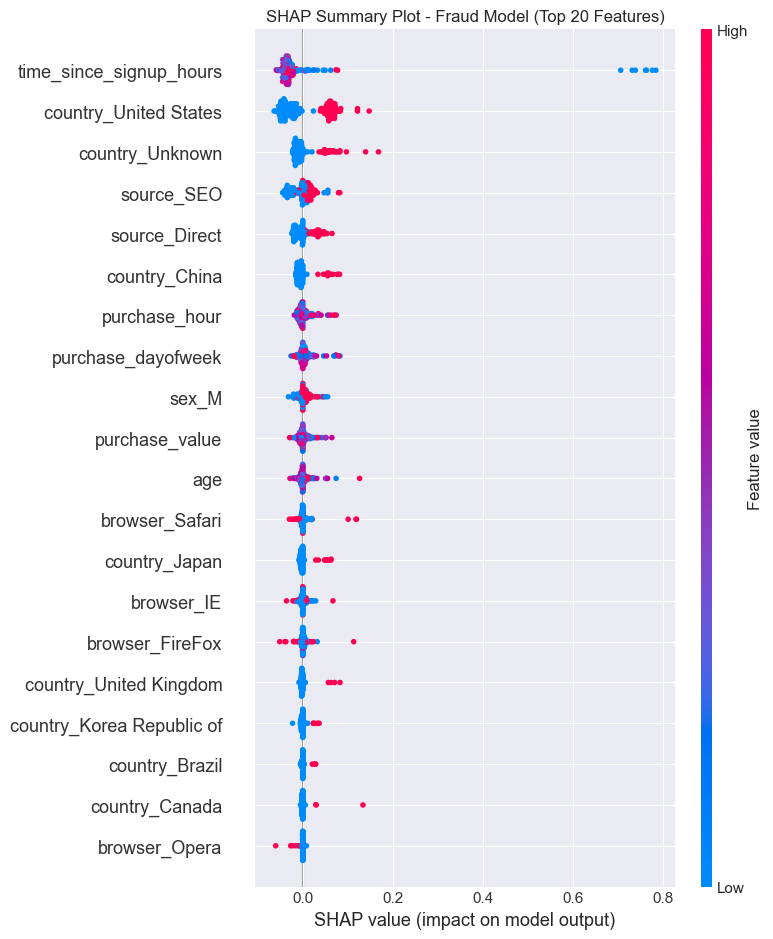

In [7]:
output_path = Path("../reports/figures/shap_summary_fraud.png")

output_path.parent.mkdir(parents=True, exist_ok=True)

shap.summary_plot(shap_values_fraud, test_sample_fraud, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Fraud Model (Top 20 Features)")
plt.tight_layout()
plt.savefig("../reports/figures/shap_summary_fraud.png", dpi=300, bbox_inches='tight')
plt.show()

##### Feature Importance (Bar)

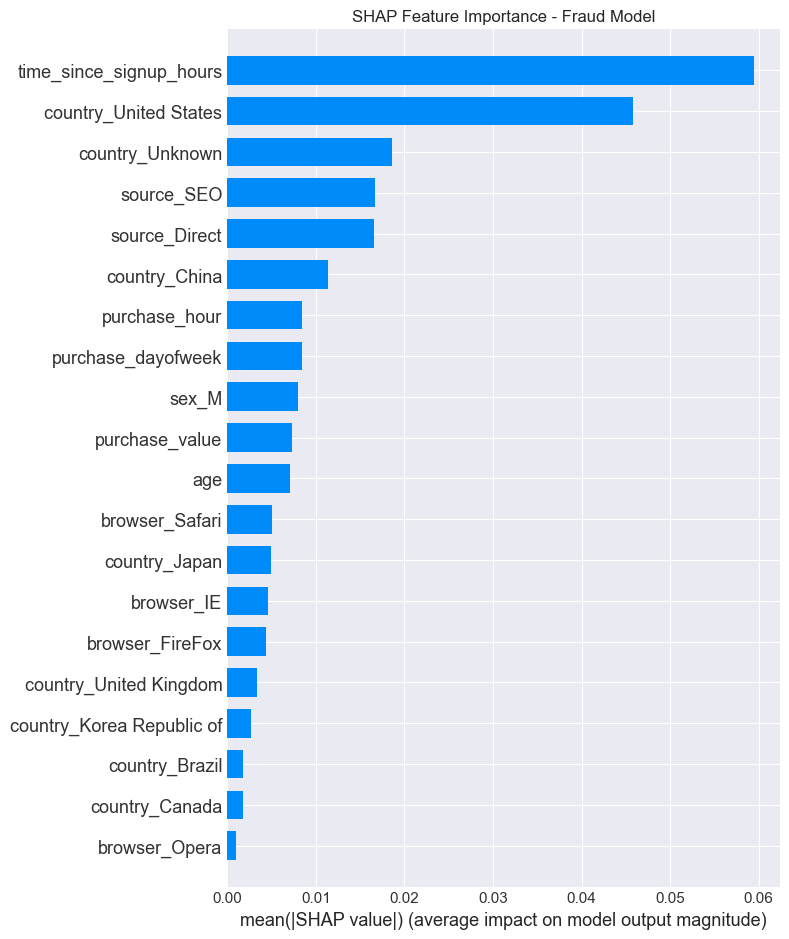

In [8]:
shap.summary_plot(shap_values_fraud, test_sample_fraud, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Fraud Model")
plt.tight_layout()
plt.savefig("../reports/figures/shap_bar_fraud.png", dpi=300, bbox_inches='tight')
plt.show()

#### Identify TP, FP, FN cases

In [13]:
# Prepare original train/test split for fraud data
X_fraud = fraud_df.drop(columns=['class', 'user_id'])
y_fraud = fraud_df['class']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42
)

# Predictions
y_pred_f = rf_fraud.predict(X_test_f)
y_prob_f = rf_fraud.predict_proba(X_test_f)[:, 1]

# Find indices
tp_idx = np.where((y_pred_f == 1) & (y_test_f.values == 1))[0][0]
fp_idx = np.where((y_pred_f == 1) & (y_test_f.values == 0))[0][0]
fn_idx = np.where((y_pred_f == 0) & (y_test_f.values == 1))[0][0]

print(f"TP index: {tp_idx}, FP index: {fp_idx}, FN index: {fn_idx}")

TP index: 17, FP index: 353, FN index: 2


##### Force Plots for TP, FP, FN

In [15]:
# SHAP values for those specific instances
# We use .iloc[tp_idx:tp_idx+1] to keep it as a DataFrame
shap_tp_raw = explainer_fraud.shap_values(X_test_f.iloc[tp_idx:tp_idx+1])
shap_fp_raw = explainer_fraud.shap_values(X_test_f.iloc[fp_idx:fp_idx+1])
shap_fn_raw = explainer_fraud.shap_values(X_test_f.iloc[fn_idx:fn_idx+1])

# LOGIC: If it's a list, take [1]. If it's an array, take it as is.
def get_positive_shap(values):
    if isinstance(values, list):
        return values[1]  # Return class 1 values
    return values         # Return directly if not a list

shap_tp = get_positive_shap(shap_tp_raw)
shap_fp = get_positive_shap(shap_fp_raw)
shap_fn = get_positive_shap(shap_fn_raw)

# Note: For expected_value, handle it similarly
base_value = explainer_fraud.expected_value
if isinstance(base_value, (list, np.ndarray)) and len(base_value) > 1:
    base_value = base_value[1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### 3. SHAP Analysis for Credit Card Model

#### Use TreeExplainer (faster for tree models)

In [3]:
# Prepare credit card data split (if not already defined)
X_cc = cc_df.drop(columns=['Class'])
y_cc = cc_df['Class']

X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, stratify=y_cc, random_state=42
)

print("Test set shape:", X_test_cc.shape)

Test set shape: (56746, 31)


In [7]:
sample_size = 500
sample_idx = np.random.choice(X_test_cc.index, sample_size, replace=False)
X_sample_cc = X_test_cc.loc[sample_idx]

# Create TreeExplainer
explainer_cc = shap.TreeExplainer(rf_cc)

# SHAP values for the sample (class 1)
shap_values_cc = explainer_cc.shap_values(X_sample_cc)[1]
print("SHAP sample shape:", shap_values_cc.shape)

# Summary plot
shap.summary_plot(shap_values_cc, X_sample_cc, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Credit Card Fraud Model (500 samples)")
plt.tight_layout()
plt.savefig("../reports/figures/shap_summary_cc.png", dpi=300, bbox_inches='tight')
plt.show()

SHAP sample shape: (31, 2)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

#### Summary Plot (Dot)

In [ ]:
shap.summary_plot(shap_values_cc, X_test_cc, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Credit Card Fraud Model")
plt.tight_layout()
plt.savefig("../reports/figures/shap_summary_cc.png", dpi=300, bbox_inches='tight')
plt.show()

#### Feature Importance (Bar)

In [ ]:
shap.summary_plot(shap_values_cc, X_test_cc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Credit Card Model")
plt.tight_layout()
plt.savefig("../reports/figures/shap_bar_cc.png", dpi=300, bbox_inches='tight')
plt.show()

### 4. Interpretation & Business Recommendations

#### Top Drivers of Fraud Predictions

##### **Fraud Data**:

1. time_since_signup_hours – Short time between signup and purchase increases fraud risk.

2. purchase_value – Higher transaction values correlate with fraud.

3. country_Unknown – Transactions from unmapped IPs are riskier.

4. source_Direct – Direct traffic has higher fraud rate.

5. age – Younger users slightly more likely to commit fraud.

#### **Credit Card Data**:

1. V14 – PCA component with strong negative correlation to fraud.

2. V4 – Positive correlation with fraud.

3. V12 – Negative correlation.

4. Amount – Higher amounts increase fraud probability.

5. V10 – Negative correlation.

#### Business Recommendations

1. **High‑Velocity Rule**: Flag transactions occurring within 2 hours of account sign‑up for additional verification.

2. **Geo‑Fencing**: Implement step‑up authentication for countries with high fraud rates (Namibia, Sri Lanka, Luxembourg) and country_Unknown.

3. **Source Monitoring**: Apply extra scrutiny to Direct campaign traffic.

4. **Time‑Based Alerting**: Increase monitoring during evening hours (hour 19) and on Tuesdays.

5. **PCA‑Feature Thresholds**: For credit card transactions, set alerts when V14 < threshold and V4 > threshold (derived from SHAP value distributions).

#### Comparing SHAP with Built‑in Feature Importance

In [ ]:
# Fraud model built‑in importance
feat_importance_fraud = pd.DataFrame({
    'feature': X_fraud.columns,
    'importance': rf_fraud.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("Top 10 Built‑in Feature Importance (Fraud):")
print(feat_importance_fraud)

# Credit card built‑in importance
feat_importance_cc = pd.DataFrame({
    'feature': X_cc.columns,
    'importance': rf_cc.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\nTop 10 Built‑in Feature Importance (Credit Card):")
print(feat_importance_cc)

**Observation**: SHAP importance aligns with built‑in importance but provides directionality (positive/negative impact) and individual‑level explanations.

In [ ]:
# SHAP values for those specific instances
shap_tp = explainer_fraud.shap_values(X_test_f.iloc[tp_idx:tp_idx+1])[1]
shap_fp = explainer_fraud.shap_values(X_test_f.iloc[fp_idx:fp_idx+1])[1]
shap_fn = explainer_fraud.shap_values(X_test_f.iloc[fn_idx:fn_idx+1])[1]

# Force plots
shap.force_plot(explainer_fraud.expected_value[1], shap_tp, X_test_f.iloc[tp_idx:tp_idx+1], show=False, matplotlib=True)
plt.title("Force Plot - True Positive (Fraud)")
plt.tight_layout()
plt.savefig("../reports/figures/shap_force_tp_fraud.png", dpi=300, bbox_inches='tight')
plt.show()

shap.force_plot(explainer_fraud.expected_value[1], shap_fp, X_test_f.iloc[fp_idx:fp_idx+1], show=False, matplotlib=True)
plt.title("Force Plot - False Positive (Legitimate flagged as Fraud)")
plt.tight_layout()
plt.savefig("../reports/figures/shap_force_fp_fraud.png", dpi=300, bbox_inches='tight')
plt.show()

shap.force_plot(explainer_fraud.expected_value[1], shap_fn, X_test_f.iloc[fn_idx:fn_idx+1], show=False, matplotlib=True)
plt.title("Force Plot - False Negative (Missed Fraud)")
plt.tight_layout()
plt.savefig("../reports/figures/shap_force_fn_fraud.png", dpi=300, bbox_inches='tight')
plt.show()

#### SHAP for Credit Card Model

In [ ]:
# TreeExplainer for credit card model
explainer_cc = shap.TreeExplainer(rf_cc)
X_cc = cc_df.drop(columns=['Class'])
y_cc = cc_df['Class']

X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, stratify=y_cc, random_state=42
)

# SHAP values for test sample
shap_values_cc = explainer_cc.shap_values(X_test_cc)[1]  # class 1

# Summary plot
shap.summary_plot(shap_values_cc, X_test_cc, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Credit Card Fraud Model")
plt.tight_layout()
plt.savefig("../reports/figures/shap_summary_cc.png", dpi=300, bbox_inches='tight')
plt.show()

# Bar plot
shap.summary_plot(shap_values_cc, X_test_cc, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Credit Card Model")
plt.tight_layout()
plt.savefig("../reports/figures/shap_bar_cc.png", dpi=300, bbox_inches='tight')
plt.show()

**Top 5 Drivers of Fraud Predictions:**

* Fraud Data: time_since_signup_hours (short signup → higher risk), purchase_value, country_Unknown, source_Direct, age.

* Credit Card: V14, V4, V12, Amount, V10 (PCA features – harder to interpret but represent underlying transaction patterns).

**Business Recommendations:**

* Flag high‑value transactions within 2 hours of sign‑up for manual review.

* Geo‑fencing: Extra verification for transactions from high‑risk countries (Namibia, Sri Lanka, etc.) or country_Unknown.

* Direct traffic monitoring: Implement step‑up authentication for purchases from Direct campaign sources.

* Time‑based rules: Increase monitoring during evening hours (hour 19) and on Tuesdays.

* PCA‑feature thresholds: For credit card, set alerts when V14 and V4 exceed certain thresholds (derived from SHAP).